In [28]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from classes import WikiArts

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


In [29]:
path_labels = r'./output/path_label.csv'
path_images = r'./WikiArt_sample'

# Image pre-processing

### Transform images (normalization, resize, to tensor)

In [30]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# transform = transforms.Compose([transforms.ToPILImage(),
#                                       transforms.ToTensor(),
#                                       transforms.Normalize(mean,std)])

transform = transforms.Compose([transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        
data = WikiArts(path_labels, path_images, transform)


In [31]:
data.__getitem__(1)

(tensor([[[-1.1589, -1.1418, -1.2103,  ..., -1.1247, -1.1247, -1.1247],
          [-1.2617, -1.2274, -1.2788,  ..., -1.1760, -1.1760, -1.1589],
          [-1.2445, -1.1932, -1.1932,  ..., -1.1932, -1.1932, -1.1760],
          ...,
          [-1.7069, -1.6898, -1.6555,  ..., -0.1828,  0.0227,  0.2282],
          [-1.7069, -1.6727, -1.6555,  ..., -0.1999, -0.0287,  0.1597],
          [-1.6213, -1.6213, -1.6555,  ..., -0.2171, -0.0801,  0.0569]],
 
         [[-0.6702, -0.6176, -0.6352,  ..., -0.5826, -0.5651, -0.5651],
          [-0.6527, -0.5651, -0.5651,  ..., -0.5651, -0.5651, -0.5301],
          [-0.6527, -0.5651, -0.5301,  ..., -0.5651, -0.5651, -0.5476],
          ...,
          [-1.0728, -1.0553, -1.0203,  ...,  0.1176,  0.3627,  0.5903],
          [-1.0728, -1.0378, -1.0203,  ...,  0.1001,  0.3102,  0.5203],
          [-0.9853, -0.9853, -1.0203,  ...,  0.0826,  0.2577,  0.4153]],
 
         [[ 0.5485,  0.6879,  0.7751,  ...,  0.7228,  0.7402,  0.7402],
          [ 0.6008,  0.7054,

### Split data

In [32]:
train_dataset, test_dataset = torch.utils.data.random_split(data, [len(data) - 2, 2])
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [len(train_dataset) - 2, 2])

### Data loaders to load data in batches

In [33]:
num_workers = 4
batch_size = 15

In [34]:
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(dataset = valid_dataset, batch_size = batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=True, num_workers=num_workers)

# Import pre-trained model

In [35]:
resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)


Using cache found in /home/hub/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [36]:
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [37]:
# Replace the last fully connected layer by a new one with the number of artists we want to classify. In our example case, let us take 2

num_classes = 4 #TO CHANGE REGARDING THE NUMBER OF ARTISTS WE WANT
resnet50.fc = torch.nn.Linear(resnet50.fc.in_features, num_classes)

In [38]:
resnet50.fc

Linear(in_features=2048, out_features=4, bias=True)

# Train the model

In [39]:
num_epochs = 15
num_classes = 4 #TO CHANGE REGARDING THE NUMBER OF ARTISTS WE WANT
learning_rate = 0.001
mom = 0.9

#### Optimizer: SGD
#### Loss function: cross entropy

In [41]:
optimizer = optim.SGD(resnet50.parameters(), lr=learning_rate, momentum=mom)

In [54]:
BEST_MODEL_PATH = 'best_model_optmiSGD_lossCrossEntrop.pth'
best_accuracy = 0.0
train_losses = []
valid_losses = []
valid_accuracies = []

for epoch in range(num_epochs):
    train_loss = 0.0
    valid_loss = 0.0

    # Train set
    resnet50.eval()
    for images, labels in iter(train_loader):
        optimizer.zero_grad()
        outputs = resnet50(images)
        labels=torch.from_numpy(
            np.array([labels[i] for i in range (len(labels))])).long()
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    
    # Valid set
    resnet50.eval()
    valid_error_count = 0.0
    for data, target in valid_loader:      
        outputs = resnet50(images)
        loss = F.cross_entropy(outputs, labels)
        valid_loss += loss.item() * images.size(0)
        valid_error_count += float(len(labels[labels != outputs.argmax(1)]))

    # Comparison valid and test set for each epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # Calculate accuracy for validation dataset
    validation_accuracy = 1.0 - float(valid_error_count) / float(len(valid_dataset))
    valid_accuracies.append(validation_accuracy)
    print('%d: %f' % (epoch, validation_accuracy))
    if validation_accuracy > best_accuracy:
        torch.save(resnet50.state_dict(), BEST_MODEL_PATH)
        best_accuracy = validation_accuracy

tensor([0.6908, 0.1164, 0.0480, 0.1448], grad_fn=<SoftmaxBackward0>)
tensor([0.2981, 0.2225, 0.0476, 0.4317], grad_fn=<SoftmaxBackward0>)
0: 0.500000
tensor([0.2942, 0.2204, 0.0482, 0.4372], grad_fn=<SoftmaxBackward0>)
tensor([0.6998, 0.1138, 0.0478, 0.1387], grad_fn=<SoftmaxBackward0>)
1: 0.500000
tensor([0.7101, 0.1102, 0.0476, 0.1321], grad_fn=<SoftmaxBackward0>)
tensor([0.2938, 0.2179, 0.0489, 0.4394], grad_fn=<SoftmaxBackward0>)
2: 0.500000
tensor([0.2932, 0.2147, 0.0498, 0.4423], grad_fn=<SoftmaxBackward0>)
tensor([0.7190, 0.1066, 0.0473, 0.1271], grad_fn=<SoftmaxBackward0>)
3: 0.500000
tensor([0.7284, 0.1027, 0.0470, 0.1219], grad_fn=<SoftmaxBackward0>)
tensor([0.2948, 0.2114, 0.0507, 0.4431], grad_fn=<SoftmaxBackward0>)
4: 0.500000
tensor([0.7366, 0.0991, 0.0467, 0.1176], grad_fn=<SoftmaxBackward0>)
tensor([0.2953, 0.2079, 0.0515, 0.4453], grad_fn=<SoftmaxBackward0>)
5: 0.500000
tensor([0.2995, 0.2032, 0.0521, 0.4452], grad_fn=<SoftmaxBackward0>)
tensor([0.7462, 0.0950, 0.0461,

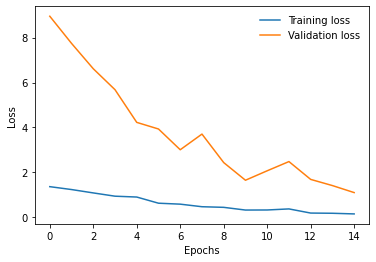

In [44]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

In [55]:
# Confirm results on test set
    # Test set
test_accuracies = []

resnet50.eval()
with torch.no_grad(): 
    test_error_count = 0.0
    for images, labels in iter(test_loader):
        outputs = resnet50(images)
        for x in outputs:
            probabilities = torch.nn.functional.softmax(x, dim=0)
            print(probabilities)
        test_error_count += float(len(labels[labels != outputs.argmax(1)]))
    test_accuracy = 1.0 - float(test_error_count) / float(len(test_dataset))
    test_accuracies.append(test_accuracy)
    print('%d: %f' % (epoch, test_accuracy))


tensor([0.8987, 0.0294, 0.0343, 0.0376])
tensor([0.9131, 0.0328, 0.0077, 0.0464])
14: 1.000000
